In [1]:
from tensorflow.keras.models import load_model
import librosa
import numpy as np
from pycoral.utils.edgetpu import make_interpreter
import time
import os
import matplotlib.pyplot as plt

In [2]:
classes = ["bed", "bird", "cat", "dog", "down", "eight", "five", "four", "go", "happy", "house", "left", "marvel", "nine", "no", "off", "on", "one", "right", "seven", "sheila", "six", "stop", "three", "tree", "two", "up", "wow", "yes", "zero"]

data_dir = 'audios'
sample_rate = 16000
n_mfcc = 40
max_pad_len = 173  

In [3]:
def preprocess_audio_coral(file_path):
    
    x, sr = librosa.load(file_path, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)
    
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    elif mfccs.shape[1] > max_pad_len:
        mfccs = mfccs[:, :max_pad_len]
    
    mfccs = np.expand_dims(mfccs, axis=0) 
    mfccs = np.expand_dims(mfccs, axis=-1)
    
    return mfccs

In [4]:
def preprocess_audio_keras(file_path, sample_rate=16000, n_mfcc=40, max_pad_len=173):
    x, sr = librosa.load(file_path, sr=sample_rate)
    
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)
    
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    elif mfccs.shape[1] > max_pad_len:
        mfccs = mfccs[:, :max_pad_len]
    
    mfccs = mfccs[np.newaxis, ..., np.newaxis]

    return mfccs

In [5]:
def predict_coral(audio):
    input_data = preprocess_audio_coral(audio)

    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]['index'], input_data)

    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()

    output_details = interpreter.get_output_details()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    predicted_class = np.argmax(output_data, axis=1)[0]
        
    return predicted_class, end_time - start_time

In [6]:
def predict_keras(audio, model):
    input_data = preprocess_audio_keras(audio)

    start_time = time.time()
    predictions = model.predict(input_data)
    end_time = time.time()

    predicted_class = np.argmax(predictions)

    return predicted_class, end_time - start_time

In [8]:
model_keras = load_model('keyphrase_detection_model.h5')

model_path = "model_quantized_edgetpu.tflite"
interpreter = make_interpreter(model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

tests = []
true_labels = []
keras_times = []
coral_times = []
keras_preds = []
coral_preds = []

for i, class_ in enumerate(classes):
    audios = os.listdir("audios/" + class_)
    cr = 0
    for audio in audios[:5]:
        file_path = "audios/" + class_ + "/" + audio
        keras_p = predict_keras(file_path, model_keras)
        coral_p = predict_coral(file_path)  
        file_path = os.path.join("audios", class_, audio)
        keras_pred, keras_time = predict_keras(file_path, model_keras)
        coral_pred, coral_time = predict_coral(file_path)
        
        true_label = i
        tests.append((file_path, keras_pred, classes[keras_pred], keras_time, coral_pred, classes[coral_pred], coral_time))
        true_labels.append(true_label)
        keras_times.append(keras_time)
        coral_times.append(coral_time)
        keras_preds.append(keras_pred)
        coral_preds.append(coral_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [9]:
for test in tests:
    print(test)

('audios/bed/1078.wav', 0, 'bed', 0.04011797904968262, 0, 'bed', 0.0006718635559082031)
('audios/bed/1722.wav', 0, 'bed', 0.038130998611450195, 0, 'bed', 0.0006299018859863281)
('audios/bed/1044.wav', 0, 'bed', 0.0418391227722168, 0, 'bed', 0.0007150173187255859)
('audios/bed/249.wav', 0, 'bed', 0.05393624305725098, 0, 'bed', 0.0028209686279296875)
('audios/bed/1911.wav', 0, 'bed', 0.04955005645751953, 0, 'bed', 0.0006809234619140625)
('audios/bird/1078.wav', 1, 'bird', 0.050025224685668945, 1, 'bird', 0.0006690025329589844)
('audios/bird/1722.wav', 1, 'bird', 0.044081926345825195, 1, 'bird', 0.002187013626098633)
('audios/bird/1044.wav', 1, 'bird', 0.05732607841491699, 1, 'bird', 0.0007309913635253906)
('audios/bird/249.wav', 1, 'bird', 0.046418190002441406, 1, 'bird', 0.002176046371459961)
('audios/bird/1911.wav', 1, 'bird', 0.0507352352142334, 1, 'bird', 0.0006940364837646484)
('audios/cat/1078.wav', 2, 'cat', 0.04617595672607422, 2, 'cat', 0.0007050037384033203)
('audios/cat/1722.w

/var/folders/t6/vh6cj7855sg6gzc_7z16j95c0000gn/T/ipykernel_10396/1102928322.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([keras_times, coral_times], labels=['Keras', 'Coral (Edge TPU)'])


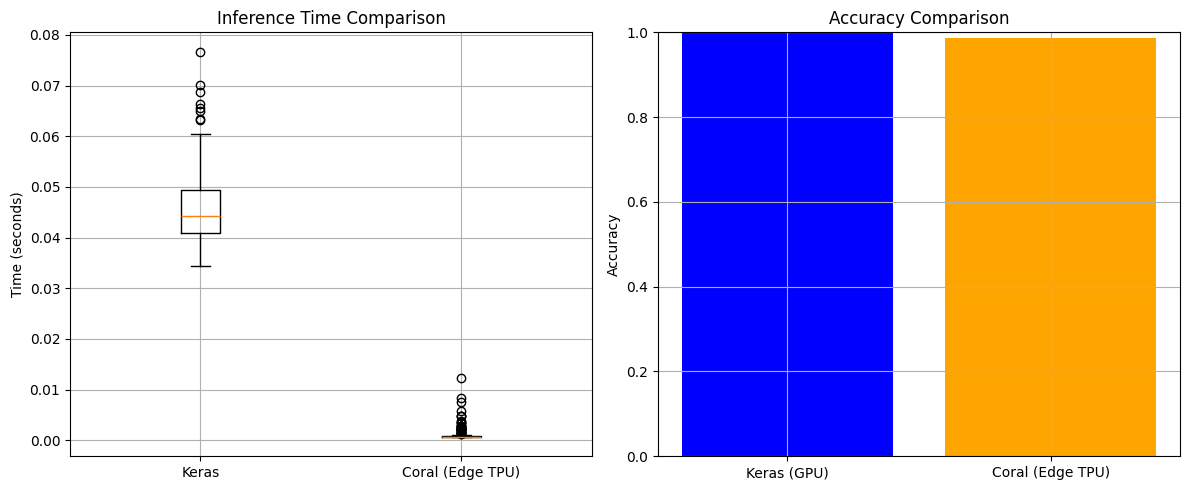

In [14]:
keras_accuracy = np.mean(np.array(keras_preds) == np.array(true_labels))
coral_accuracy = np.mean(np.array(coral_preds) == np.array(true_labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot([keras_times, coral_times], labels=['Keras', 'Coral (Edge TPU)'])
plt.title('Inference Time Comparison')
plt.ylabel('Time (seconds)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(['Keras (GPU)', 'Coral (Edge TPU)'], [keras_accuracy, coral_accuracy], color=['blue', 'orange'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()